<h2><u>Question-3: Gaussian Mixture Models (GMMs)</u></h2>

In [ ]:
import numpy as np
from scipy.stats import norm
import nibabel as nib
import matplotlib.pyplot as plt

In [ ]:
class GMM:
    def __init__(self, k, epochs=5):
        self.k = k
        self.epochs = epochs

    def initialize(self, x):
        np.random.seed(45)
        self.pi = np.ones((self.k)) / self.k
        self.means = np.random.choice(x, self.k)
        self.variances = np.random.random_sample(size=self.k)

    # Expection - update weights
    def e_step(self, x):
        weights = np.zeros((self.k,len(x)))
        for j in range(self.k):
            # weights[j,:] = norm(loc=self.means[j],scale=np.sqrt(self.variances[j])).pdf(x)
            var = self.variances[j] + 1e-6
            weights[j, :] = (1 / np.sqrt(2 * np.pi * var)) * np.exp(-((x - self.means[j]) ** 2) / (2 * var))
        return weights

    # Maximization - update mean and variance
    def m_step(self, x, weights):
        r = []
        for j in range(self.k):
            r.append((weights[j] * self.pi[j]) / (np.sum([weights[i] * self.pi[i] for i in range(self.k)], axis=0) + 1e-6))

            self.means[j] = np.sum(r[j] * x) / (np.sum(r[j]) + 1e-6)
            self.variances[j] = np.sum(r[j] * np.square(x - self.means[j])) / (np.sum(r[j]) + 1e-6)

            self.pi[j] = np.mean(r[j])

    def train_gmm(self, data):
      self.initialize(data)
      for step in range(self.epochs):
          weights = self.e_step(data)
          self.m_step(data, weights)

    def predict(self, x):
        weights = self.e_step(x)
        r = np.zeros((self.k, len(x)))
        for j in range(self.k):
            r[j, :] = (weights[j] * self.pi[j]) / (np.sum([weights[i] * self.pi[i] for i in range(self.k)], axis=0)+ 1e-6)

        return np.argmax(r, axis=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


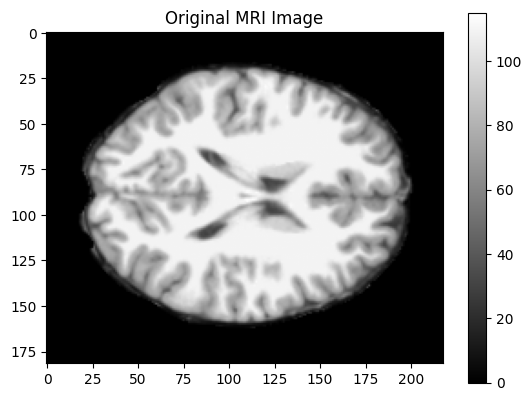

In [ ]:
img_nib = nib.load("/content/drive/MyDrive/smai_a2/sald_031764_img.nii")
img = img_nib.get_fdata()

z_mid = img.shape[-1] // 2
img = img[:, :, z_mid]
original = img

plt.figure()
plt.imshow(img, cmap='gray')
plt.title('Original MRI Image')
plt.colorbar()
plt.show()

In [ ]:
print(original.shape)
img = img.flatten()
print(img.shape)

gmm = GMM(k=4, epochs=50)
gmm.train_gmm(img)

(182, 218)
(39676,)


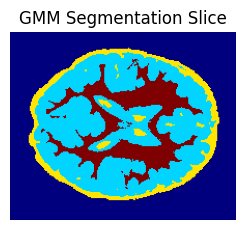

In [ ]:
segments = gmm.predict(img)
segmented_img = segments.reshape(original.shape)

segmented_nii = nib.Nifti1Image(segmented_img.astype(np.uint8), affine=img_nib.affine)
nib.save(segmented_nii, "/content/drive/MyDrive/smai_a2/segmented.nii")

plt.figure()
plt.subplot(1, 2, 2)
plt.imshow(segmented_img, cmap='jet')
plt.title("GMM Segmentation Slice")
plt.axis('off')
plt.show()

In [ ]:
sorted_clusters = np.argsort(gmm.means)

background_label = sorted_clusters[0]
csf_label = sorted_clusters[1]
gm_label = sorted_clusters[2]
wm_label = sorted_clusters[3]

segmented_gm = (segmented_img == gm_label).astype(int)
segmented_wm = (segmented_img == wm_label).astype(int)
segmented_csf = (segmented_img == csf_label).astype(int)

print("GM Label:", gm_label)
print("WM Label:", wm_label)
print("CSF Label:", csf_label)

total_pixels = segmented_img.size
gm_percentage = (np.sum(segmented_gm) / total_pixels) * 100
wm_percentage = (np.sum(segmented_wm) / total_pixels) * 100
csf_percentage = (np.sum(segmented_csf) / total_pixels) * 100

print(f"Gray Matter (GM) Percentage: {gm_percentage:.2f}%")
print(f"White Matter (WM) Percentage: {wm_percentage:.2f}%")
print(f"Cerebrospinal Fluid (CSF) Percentage: {csf_percentage:.2f}%")

GM Label: 1
WM Label: 3
CSF Label: 2
Gray Matter (GM) Percentage: 32.36%
White Matter (WM) Percentage: 13.36%
Cerebrospinal Fluid (CSF) Percentage: 7.35%


In [ ]:
gm_mask = nib.load("/content/drive/MyDrive/smai_a2/sald_031764_probmask_graymatter.nii").get_fdata()
wm_mask = nib.load("/content/drive/MyDrive/smai_a2/sald_031764_probmask_whitematter.nii").get_fdata()
csf_mask = nib.load("/content/drive/MyDrive/smai_a2/sald_031764_probmask_csf.nii").get_fdata()

z_mid = csf_mask.shape[-1] // 2
csf_mask = csf_mask[:, :, z_mid]
gm_mask = gm_mask[:, :, z_mid]
wm_mask = wm_mask[:, :, z_mid]

prob_gm = (gm_mask > 0.5).astype(int)
prob_wm = (wm_mask > 0.5).astype(int)
prob_csf = (csf_mask  > 0.5).astype(int)

predictions = (segmented_gm == prob_gm) & (segmented_wm == prob_wm) & (segmented_csf == prob_csf)
accuracy = np.mean(predictions)

print(f"Pointwise segmentation accuracy: {accuracy:.4f}")

Pointwise segmentation accuracy: 0.8960


In [ ]:
def gaussian_pdf(x, mean, var):
    return (1 / np.sqrt(2 * np.pi * (var + 1e-6))) * np.exp(-0.5 * ((x - mean) ** 2) / (var+1e-6))

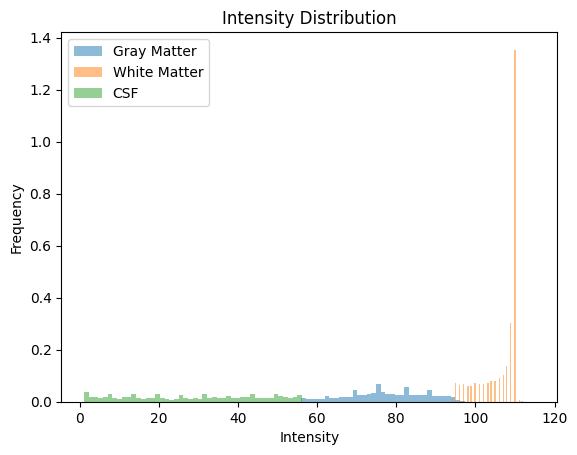

In [ ]:
gm_intensity = original[prob_gm == 1]
wm_intensity = original[prob_wm == 1]
csf_intensity = original[prob_csf == 1]

x = np.linspace(img.min(), img.max(), 1000)

plt.figure()
plt.hist(gm_intensity, bins=50, alpha=0.5, label="Gray Matter", density=True)
plt.hist(wm_intensity, bins=50, alpha=0.5, label="White Matter", density=True)
plt.hist(csf_intensity, bins=50, alpha=0.5, label="CSF", density=True)

plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.title("Intensity Distribution")
plt.show()

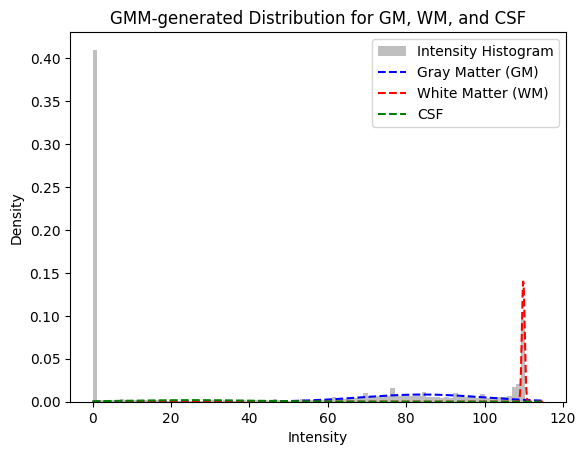

In [ ]:
means = np.array([gmm.means[1], gmm.means[3], gmm.means[2]])
variances = np.array([gmm.variances[1], gmm.variances[3], gmm.variances[2]])
weights = np.array([gmm.pi[1], gmm.pi[3], gmm.pi[2]])

colors = ["b", "r", "g"]
labels = ["Gray Matter (GM)", "White Matter (WM)", "CSF"]

plt.hist(img, bins=100, density=True, alpha=0.5, label="Intensity Histogram", color="gray")

for mean, var, weight, color, label in zip(means, variances, weights, colors, labels):
    plt.plot(x, weight * gaussian_pdf(x, mean, var), linestyle="dashed", color=color, label=label)

plt.xlabel("Intensity")
plt.ylabel("Density")
plt.legend()
plt.title("GMM-generated Distribution for GM, WM, and CSF")
plt.show()

<h4><u>Report</u></h4>
The highest misclassification would be between CerebroSpinal Fluid (CSF) and Gray Matter (GM). From the above graph, it is clear that both of them occupy very similar intensity ranges and slightly overlap with each other. This overlap could lead to improper segmentation - especially when noise is also present in the picture.

<b>Point-wise accuracy:</b> 89.60